# Time-series data stationarization on Salesforce's share price example

<a href='https://en.wikipedia.org/wiki/Salesforce'> Salesforce.com, inc.</a> is an American cloud-based software company headquartered in San Francisco, California. It provides customer relationship management (CRM) service and also sells a complementary suite of enterprise applications focused on customer service, marketing automation, analytics, and application development (Wikipedia).

The data set is from <a href= 'https://www.alphavantage.co/#about'> alphavantage </a>. It is very easy to obtain the stock price information from the website. Just follow the documentation.

Before everything esle, we need data. So let's get it!

In [ ]:
# API Key:LX71H2XX0HSO5PAO 

Let's upload required library...

In [5]:
import requests
import json
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

import statsmodels.api as sm
import warnings
from itertools import product

warnings.filterwarnings('ignore')
# plt.style.use('seaborn-poster')

In [2]:
# getting the data from aplhavantage using API key
url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=CRM&outputsize=full&apikey=LX71H2XX0HSO5PAO'
resp = requests.get(url)
resp.json()['Meta Data']

{'1. Information': 'Daily Time Series with Splits and Dividend Events',
 '2. Symbol': 'CRM',
 '3. Last Refreshed': '2020-02-21',
 '4. Output Size': 'Full size',
 '5. Time Zone': 'US/Eastern'}

As you can see, the Meta Data node contains the data that we need.

In [3]:
df = pd.DataFrame(resp.json()['Time Series (Daily)']) # converting json to dataframe

In [4]:
df.tail() # initial look of df

,2020-02-21,2020-02-20,2020-02-19,2020-02-18,2020-02-14,2020-02-13,2020-02-12,2020-02-11,2020-02-10,2020-02-07,...,2004-07-07,2004-07-06,2004-07-02,2004-07-01,2004-06-30,2004-06-29,2004-06-28,2004-06-25,2004-06-24,2004-06-23
4. close,189.5000,193.3600,192.8700,191.0900,189.9500,188.6400,189.4600,189.1100,189.1200,185.7200,...,16.3100,17.0000,16.9800,16.0300,16.0700,16.4000,16.0000,15.8000,16.7600,17.2000
5. adjusted close,189.5000,193.3600,192.8700,191.0900,189.9500,188.6400,189.4600,189.1100,189.1200,185.7200,...,4.0775,4.2500,4.2450,4.0075,4.0175,4.1000,4.0000,3.9500,4.1900,4.3000
6. volume,5241904,5449529,3901401,4957013,3598651,3129214,4533345,4298229,3872433,3712487,...,446900,304200,248300,438700,521900,528000,567700,1677500,2221800,10893600
7. dividend amount,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
8. split coefficient,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,...,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


We need to transpose our table to have proper format for the analysis and forecasting. Rows will be columsn, and columns should be converted to rows.

In [5]:
# saving as csv
# df.to_csv('CRM_stock')

In [6]:
# transposing the dataframe
pd.to_datetime(df.columns)
df_transposed = df.transpose().set_index(df.columns)

In [7]:
df_transposed.head() # initial look

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
2020-02-21,191.8400,192.0400,186.7200,189.5000,189.5000,5241904,0.0000,1.0000
2020-02-20,194.0000,195.7200,189.7700,193.3600,193.3600,5449529,0.0000,1.0000
2020-02-19,192.0000,193.9200,191.8000,192.8700,192.8700,3901401,0.0000,1.0000
2020-02-18,190.9500,191.5000,188.9200,191.0900,191.0900,4957013,0.0000,1.0000
2020-02-14,189.3500,190.2500,188.1000,189.9500,189.9500,3598651,0.0000,1.0000


Now that we have proper format, we should drop irrelevant columns. For simplicity, I will keep ajusted close, and volume columns.

In [8]:
# removing unused features
df_transposed.drop(columns=['1. open','2. high', '3. low', '4. close','7. dividend amount','8. split coefficient'],inplace=True)

In [9]:
df_transposed.head() 

,5. adjusted close,6. volume
2020-02-21,189.5000,5241904
2020-02-20,193.3600,5449529
2020-02-19,192.8700,3901401
2020-02-18,191.0900,4957013
2020-02-14,189.9500,3598651


Let's convert data types to float. We can do that using astype method of pandas library.

In [10]:
# converting dtypes to float
df_transposed['5. adjusted close'] = df_transposed['5. adjusted close'].astype(float)
df_transposed['6. volume'] = df_transposed['6. volume'].astype(float)

In [11]:
df_transposed.sort_index(ascending=True,inplace=True) # sorting in ascending format

In [12]:
df_transposed.index = pd.to_datetime(df_transposed.index) # converting indices to datetime

In [13]:
df_transposed.index

DatetimeIndex(['2004-06-23', '2004-06-24', '2004-06-25', '2004-06-28',
               '2004-06-29', '2004-06-30', '2004-07-01', '2004-07-02',
               '2004-07-06', '2004-07-07',
               ...
               '2020-02-07', '2020-02-10', '2020-02-11', '2020-02-12',
               '2020-02-13', '2020-02-14', '2020-02-18', '2020-02-19',
               '2020-02-20', '2020-02-21'],
              dtype='datetime64[ns]', length=3944, freq=None)

Let's split the data to weekly,monthly, quarterly, and yearly basis. There is no actual purpose for doing  it. I just want to see how the stock price action looks on the chart on various time-frames.

In [14]:
# resampling to weekly, monthly, quarterly and yearly periods

df_weekly = df_transposed.resample('W').mean()
df_monthly = df_transposed.resample('M').mean()
df_quart = df_transposed.resample('Q-DEC').mean()
df_annual = df_transposed.resample('A-DEC').mean()

In [15]:
df_weekly.head()

,5. adjusted close,6. volume
2004-06-27,4.146667,4.930967e+06
2004-07-04,4.074000,4.609200e+05
2004-07-11,4.090625,3.612750e+05
2004-07-18,3.991000,4.952800e+05
2004-07-25,3.489500,2.005720e+06


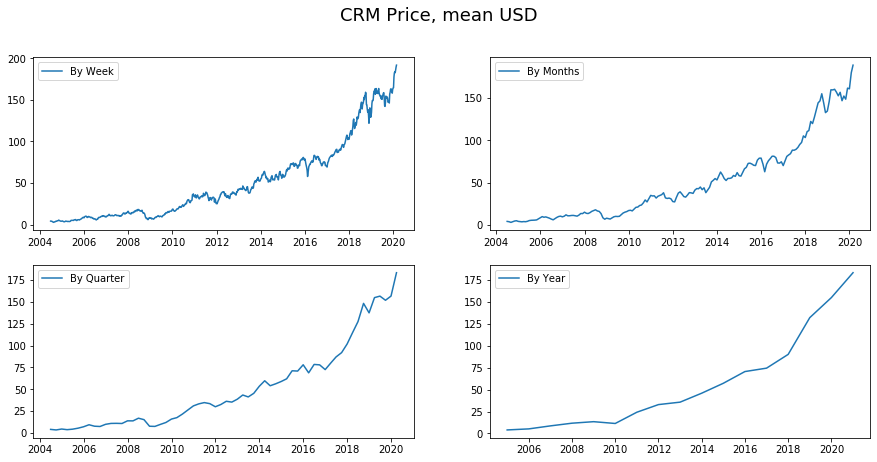

In [16]:
# plots

fig = plt.figure(figsize=[15, 7])
plt.suptitle('CRM Price, mean USD', fontsize=18)

plt.subplot(221)
plt.plot(df_weekly['5. adjusted close'], '-', label='By Week')
plt.legend()

plt.subplot(222)
plt.plot(df_monthly['5. adjusted close'], '-', label='By Months')
plt.legend()

plt.subplot(223)
plt.plot(df_quart['5. adjusted close'], '-', label='By Quarter')
plt.legend()

plt.subplot(224)
plt.plot(df_annual['5. adjusted close'], '-', label='By Year')
plt.legend()

# plt.tight_layout()
plt.show()

We can see on the graph when we take average of larger time periods the line gets smoother and smoother. I will predict monthly stock price of the Salesforce Inc. 

In [17]:
# rename price column
def rename_col(df,col):
    df.rename(columns={col: "Price"},inplace=True)

In [18]:
#renaming
rename_col(df_weekly,'5. adjusted close')
rename_col(df_monthly,'5. adjusted close')
rename_col(df_quart,'5. adjusted close')
rename_col(df_annual,'5. adjusted close')

# Stationarity Check

In statistic, and in time-series analysis we need to check the data for stationarity. If the data is non-stationary we convert to stationary. 

In the most intuitive sense, <a href= 'https://towardsdatascience.com/stationarity-in-time-series-analysis-90c94f27322'> stationarity </a> means that the statistical properties of a process generating a time series do not change over time. 

Little function below plots seasonal decomposition of a time-series data, and returns p-value of Dickey-Fuller test.

In [19]:
# dickey-fuller test for stationary check
def DF_test(df):
    plt.figure(figsize=[10,5])
    sm.tsa.seasonal_decompose(df.Price).plot()
    print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df.Price)[1])
    plt.show()

## Dickey-Fuller Test

In statistics, the Dickey–Fuller test tests the null hypothesis that a unit root is present in an autoregressive model. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity. It is named after the statisticians David Dickey and Wayne Fuller, who developed the test in 1979 (<a href='https://en.wikipedia.org/wiki/Dickey–Fuller_test'>Wikipedia</a>)

### Seasonal Decomposition

It is a technique to analyze time-series data. Obeserved data is split into 3 parts: Trend, Seasonal, and Residuals (noise).

* Trend is basically direction of an obeserved data at a time. In our case, the stock price is in up-trend.
* Seasonal data reveals patterns in data that is affected by seasonal factors, and it's repeatly occurs within certain time-frame.
* Residuals is a noise in the data. It is a remainder when trend and seasonality are removed.


Decomposition is primarily used for time series analysis, and as an analysis tool it can be used to inform forecasting models on your problem. It helps to break down your problem and think in structured way.


<a href ='https://en.wikipedia.org/wiki/Decomposition_of_time_series'> Learn more </a>

Dickey–Fuller test: p=1.000000


<Figure size 720x360 with 0 Axes>

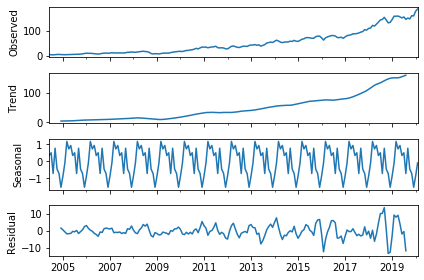

In [20]:
DF_test(df_monthly)

Dickey-Fuller test indicates that the data is not stationary as we can see on the graph. P-value is 1.0. We failed to reject null-hypothesis that our data is stationary. P-value should less than or equal to 0.05.

To achieve stationary state we can do various data tranformations. For example, let's try box-cox transformationa and see if we the data stationary...


**Box-Cox Transformation**

In statistics, a power transform is a family of functions that are applied to create a monotonic transformation of data using power functions. This is a useful data transformation technique used to stabilize variance, make the data more normal distribution-like, improve the validity of measures of association such as the Pearson correlation between variables and for other data stabilization procedures.

In [25]:
# Box-Cox Transformations
def box_cox(df):
    df['Price_box'], lmbda = stats.boxcox(df['Price'])
    print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df['Price_box'])[1])

In [27]:
df_monthly['Price_box'], lmbda = stats.boxcox(df_monthly['Price'])
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_monthly['Price_box'])[1])

Dickey–Fuller test: p=0.871254


After Box-Cox transformation our data is still non-stationary. Let's apply log transformation on the data.

In [31]:
# log tranformation
def log_transformation(df):
    df['price_log']=df['Price'].apply(lambda x: np.log(x))
    print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df['price_log'])[1])

In [2]:
# log tranformation
log_transformation(df_monthly)

NameError: name 'log_transformation' is not defined

In [33]:
# Seasonal differentiation
df_monthly['prices_box_diff'] = df_monthly.Price_box - df_monthly.Price_box.shift(12)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_monthly.prices_box_diff[12:])[1])

Dickey–Fuller test: p=0.003912


Dickey–Fuller test: p=0.003912


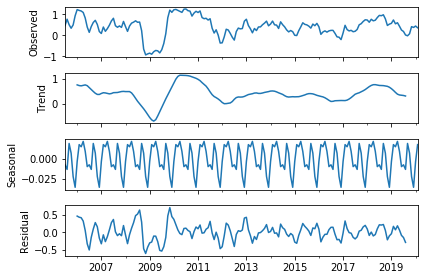

In [34]:
sm.tsa.seasonal_decompose(df_monthly['prices_box_diff'][13:]).plot()   
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_monthly['prices_box_diff'][12:])[1])

plt.show()

Now our data is stationarized, so we can move to predicting. You can check <a href='https://medium.com/@aabdygaziev/salesforce-inc-stock-price-prediction-time-series-analysis-299bc3f1b631'> Salesforce stock price prediction' </a> on my Medium blog post.